## A Tour of Dimensionality Reduction
___________________________

### Introduction

We as human beings are inherently contrained by three spacial dimensions. This poses a problem because almost all data of real interest contains many more dimensions (in features) than we could easily comprehend or display. Genomics data might have, for instance, tens or hundreds of thousands of independent factors to consider. Thankfully, **dimensionality reduction** techniques allow us to distill key factors from the original data. Dimension reduction helps us efficiently represent data and understand it better. 

In this notebook, we will explore the MNIST handwritten digits data set, very commonly used for computer vision research. This is a set of grayscale 28x28 pixel images. Each pixel value is represented by a number, 0 being completely dark and 1 being completely bright. Unraveling the 28x28 matrix into a vector of 784 numerical values gives us a naive but common method to represent each digit.

In [3]:
import pickle, gzip
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline

In [4]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train, test, val = pickle.load(f, encoding='latin1')
    mnist_digit, mnist_label = train

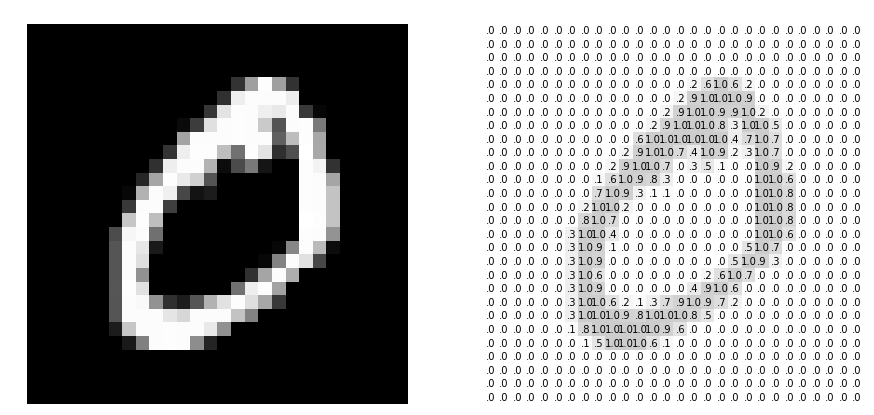

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (15, 15))

ax[0].matshow(mnist_digit[1].reshape((28,28)), cmap='gray', clim=(0,1))
ax[0].axis('off')

ax[1].matshow(1 - (mnist_digit[1] / 5).reshape((28,28)), cmap='gray', clim=(0,1))
ax[1].axis('off')

c = 0
for i in range(28):
    for j in range(28):
        ax[1].text(j, i, '{:.1f}'.format(mnist_digit[1][c]).lstrip('0'), ha='center', va='center')
        c += 1
    
pass

Our feature space is now a 784-dimensional cube with each axis corresponding to a given pixel intensity. Each instance of a digit is a point in this space. For example, the point at the origin represents the image of all black pixels. If we plotted all the points in the MNIST data set like this, how do we expect the points to be distributed?

Intuition should tell us that the digits are sparsely distributed  - a typical point in this space would look more like white noise than a recognizible image. We also expect many of the pixels to be non-informative. Almost all pixels on the edges are dark (because MNIST digits are centered and scaled). Although each image is embedded in a 784-dimensional space, the MNIST images are inherently lower dimensional. 

### Principal Components Analysis

We expect that similar images group together in feature-space. We might expect a group of points corresponding to the zero's and another for ones's. To confirm our suspicions, we would need a way to project the higher dimensional data to a lower dimensional set. One way is to imagine rotating the 784-dimensional cube and projecting the points down to a plane as if we were shining a light and observing the resulting shadows. Trying to imagine that many dimensions is intractable so let's consider a much simpler case.

Suppose we have a three dimensional cloud of points within a unit cube. Some points are colored blue and some orange. We can choose any angle to view the data. We might choose to look through one face or another, but there is no reason that this should provide the best vantage. Instead, we want to choose an angle such that the resulting projection perserves the most global structure of the data. Finding such an optimal rotation in the idea behind **Principal Components Analysis (PCA)**. 

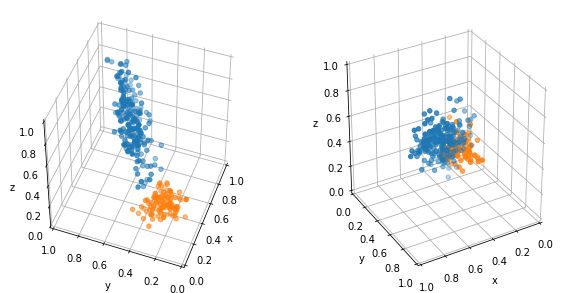

In [139]:
np.random.seed(0)
npoints = 200
from mpl_toolkits.mplot3d import Axes3D

# sample points from multivariate gaussian
mu_a = [0.6, 0.6, 0.6]
cov_a = [[0.02, 0.01, 0.01], [0.01, 0.01, 0.01], [0.01, 0.01, 0.02]]

mu_b = [0.25, 0.25, 0.25]
cov_b = [[0.005, 0, 0], [0, 0.005, 0], [0, 0, 0.005]]

samp_a = np.random.multivariate_normal(mu_a, cov_a, npoints)
samp_b = np.random.multivariate_normal(mu_b, cov_b, npoints // 2)

# plot points on 3D axis
angles = [[45, 200], [30, 60]]
fig = plt.figure(figsize=(10, 5))
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    ax.scatter(samp_a[:,0], samp_a[:,1], samp_a[:,2])
    ax.scatter(samp_b[:,0], samp_b[:,1], samp_b[:,2])
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_zlim([0,1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.view_init(angles[i][0], angles[i][1])
    
    ax.w_xaxis.set_pane_color((1, 1, 1, 1))
    ax.w_yaxis.set_pane_color((1, 1, 1, 1))
    ax.w_zaxis.set_pane_color((1, 1, 1, 1))
pass

In the above example, rotation 1 is better than rotation 2 because the points apprear to be more spread out. In other words, we wish to find a rotation (a linear transformation) that maximizes the variance of the projected data. PCA finds the optimal orthogonal basis such that the most varience falls on the first basis or **principal component**, the next largest amount on the second, and so forth. Because sucessive principal components are less important and principal components are necessarily independent, we can reduce dimensions by selecting the first $k$ components and discarding the rest. In a sense we have created new features from linear combinations of our previous ones which keeps the most variation possible. 

Below is our data set plotted using only the first two principal components. We can better see the seperation between the blue and orange points. 

In [398]:
X = np.vstack((samp_a, samp_b))
X = (X - np.mean(X, axis=0))
U, S, V = np.linalg.svd(X)

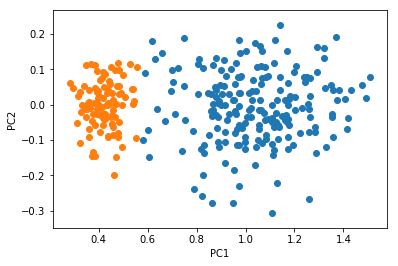

In [399]:
a_trans = samp_a @ V[0:2].T
b_trans = samp_b @ V[0:2].T
plt.scatter(a_trans[:,0], a_trans[:,1])
plt.scatter(b_trans[:,0], b_trans[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
pass

PCA works by the eigen decomposition of the covarience matrix of the data. If we have data $X$ with variables listed column-wise and each variable centered with mean 0, then the covarience matrix is given by $\Sigma = X^TX$. We can perform an eigenvalue decomposition on $\Sigma$. Alternatively, this is equivalent to performing a **singular value decomposition (SVD)** on the centered data matrix $X$. We often choose the later due to increase in numerical precision. 

SVD results is a factorization such that $X = U S V^T$. Because the covarience matrix is defined to be [positive semi-definite](https://en.wikipedia.org/wiki/Positive-definite_matrix), a diagonalization exists and the eigenvalues are always non-negative. The matrix $S$ is a diagonal matrix with elements correpsonding to the **singular values** or eigenvalues. Singular values correspond to amount of varience explained by the corresponding principal component. The columns of $V$ correspond to the principal components, the new features of our data. By ordering columns in descreasing order of varience explained, we can choose the $k$ most important principal components to keep. Finally, the product $XV_k$ projects our data into a k-dimensional space.

The intuition behind PCA is two-fold. First, the covarience matrix tells us information about the varience and correlations in our data. Capturing more variation in the data means we keep more global structure from the original to our projection. Second, due to the special properties of the covarience matrix, the orthogonal basis that maximizes the most variation preserved is the basis given by the eigenvectors of $\Sigma$ ordered by the size of the corresponding eigenvalues.

PCA is used frequently as a method to explore data. Now let's try using PCA to understand the MNIST dataset. With 784 features, it is much more complex than our three-dimensional toy example above. Visualized below is MNIST plotted on the first two principal components with each digit colored seperately. 

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(mnist_digit)
mnist_pca = pca.transform(mnist_digit)

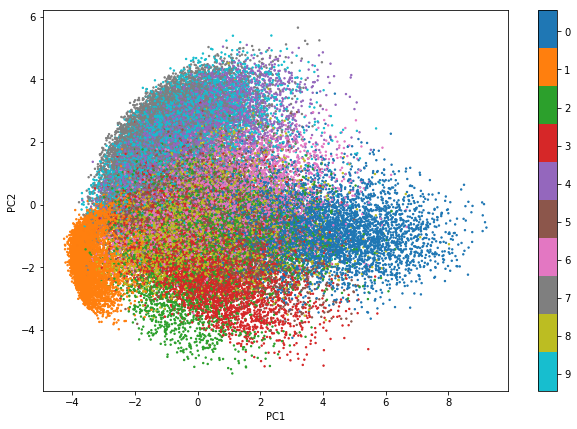

In [76]:
plt.figure(figsize=(11,7))
plt.scatter(mnist_pca[:,0], mnist_pca[:,1], c=mnist_label, s=2, cmap='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
ax = plt.gca()
ax.set_aspect('equal')

cbar = plt.colorbar()
cbar.ax.invert_yaxis() 
cbar.set_ticks(np.arange(10) * 0.9 + 0.5)
cbar.set_ticklabels(np.arange(10))
pass

We seem some seperation in the data with a nice cluster of ones towards the left and zeros generally on the right. If we visualize the first two principal components we see why. The blue colors represent positive values and the red colors are negative values. These represent rotations of our coordinates in opposite directions. Most of the variation along the first principal component seem to be zero verus one because those two digits are strongly pushed in opposite directions in our projection. The second principal component is not as clear as the first but seems to push 2's and 3's towards one side and 7's and 9's towards the other.

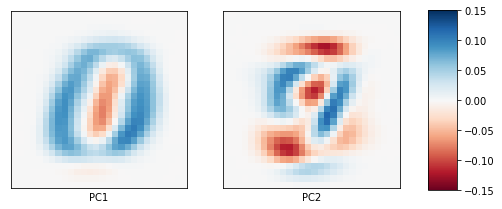

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].matshow(pca.components_[0].reshape((28, 28)), cmap='RdBu', clim=(-0.15, 0.15))

cax = ax[1].matshow(pca.components_[1].reshape((28, 28)), cmap='RdBu', clim=(-0.15, 0.15))
cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.50])
fig.subplots_adjust(right=0.8)
fig.colorbar(cax, cax=cbar_ax)

ax[0].set_xlabel('PC1')
ax[1].set_xlabel('PC2')
for i in range(2):    
    ax[i].set_xticks([])
    ax[i].set_yticks([])
pass

In [200]:
pca = PCA()
pca.fit(mnist_digit)
U = pca.components_

Although we see start to understand some structure in the data, on a whole the representation doesn't seem that good. Most of classes overlap each other with no clear seperation in the global structure. This is somewhat understandable because we are trying to compress fairly complicated images using just two principal components. We can get a sense of how much information we lose by reversing the transformation. Visualized below are images projected down into $k$-dimensional space and then reconstructed. We get very good reproductions using 150 principal components. Using 25 components, the images are becoming very blurry. Below 10 components, the images are not easily recognizable. Two principal components only retain 17% of the varience in the MNIST data set which explains why our final output isn't clearly defined. Most of the information that differentiates the digits is being thrown away when we perform our projection.

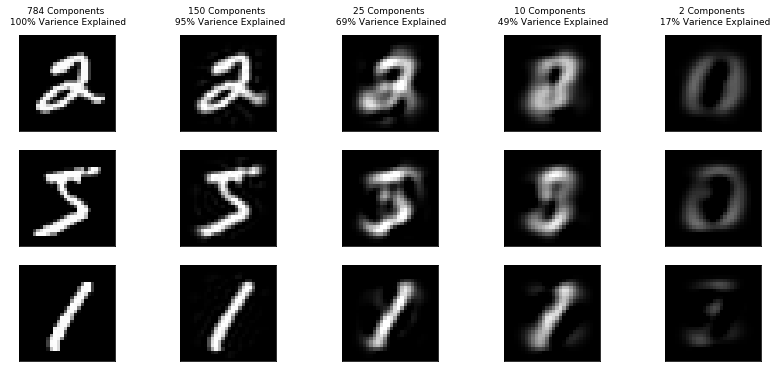

In [331]:
n_components = [784, 150, 25, 10, 2]
n_images = [5, 0, 3]
fig, ax = plt.subplots(len(n_images), len(n_components), figsize=(14, 6))
for i, n in enumerate(n_components):
    for j, im in enumerate(n_images):
        projected = mnist_digit[im, None] @ U[0:n,:].T
        reconstr  = projected @ U[0:n,:]
        ax[j, i].matshow(reconstr.reshape((28,28)), cmap='gray', clim=(0, 1))
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        
for i, n in enumerate(n_components):
    var_exp = sum(pca.explained_variance_ratio_[0:n])
    ax[0, i].set_title('{} Components \n {:.0f}% Varience Explained'.format(n, var_exp * 100), fontsize=9) 
    
pass

A limitation of PCA is that it only produces linear transformations of the data. In our toy example with the blue and orange points, PCA performs well because the data is point cloud that falls inside an elipsoid with most of the variation along one axis. However PCA would not perform as well on a data set that is inherently nonlinear. An extension that addresses this issue is called **kernel PCA**. This method produces a non-linear transformation of the data by performing PCA in a [reproducing kernel Hilbert space](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space). Issues with kPCA are that hyperparameters and choice of kernel impacts the output. Another issue is that it is slow when the number of examples is high, being [cubic in time complexity](https://cs.nju.edu.cn/zlj/pdf/AAAI-2016-Zhang.pdf).

For high computation complexity reasons, kernel PCA cannot easily be run on the MNIST data. We will explore methods of nonlinear dimension reduction in the next sections. 

In [357]:
import sklearn.datasets
roll, color = sklearn.datasets.make_swiss_roll(n_samples=2000, noise=0.0, random_state=None)

### References
_______________________________

Much of this notebook has been inspired by [this](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) post on dimension reduction methods including PCA. The connection between PCA and SVD is explained well [here](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca). Finally the geometric explaination of PCA is provided in this great [post](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues).

In [41]:
from IPython.display import HTML

In [42]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')